# Assignment 6 - Reinforcement Learning

## *BARBARA FLORES*
Netid: bpf17

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://kylebradbury.github.io/ids705/notebooks/assignment_instructions.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

## Learning objectives
After completing this assignment, you will be able to...
- Clearly articulate the role of the key components of reinforcement learning: the agent, actions, rewards, policies, state values, and action values.
- Apply policy evaluation to a problem in practice
- Use Monte Carlo control to determine and apply an optimal policy for a reinforcement learning problem and learn an optimal strategy from trial and error, alone

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack through trial-and-error learning. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1 (whichever is most advantageous to the player), and we're refer to it as a 'usable' Ace if we're treating it as 11 (indicating that it could be used as a '1', instead, if need be). This game is played with a deck of cards sampled with replacement.
- The game starts with both the player and the dealer having one face up and one face down card.
- The player can request additional cards (known as taking a "hit", which we define as action "1") until either they decide to stop (known as "staying", which we define as action '0') or their cards exceed 21 (known as a "bust", at which time the game ends and player loses).
- If the player stays (and hasn't exceeded a score of 21), the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer busts the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, tying is 0, and losing is -1.


Over the course of these exercises, you will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a naive policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [5 points] Human reinforcement learning 

Using the code detailed below, play at least 20 hands of the modified blackjack game below, and record your returns (average cumulative reward) across all episodes. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective. Since for this game, you only get a nonzero reward at the end of the episode, you can simply play the game and note the reward in a spreadsheet, then average across all plays of the game (of course, you're welcome to code up a way to do that automatically if you're so inspired).

In [1]:
import numpy as np


class Blackjack:
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.

    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.

    The game starts with each (player and dealer) having one face up and one
    face down card.

    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).

    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.

    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).

    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).

    http://incompleteideas.net/sutton/book/the-book.html

    Usage:
        Initialize the class:
            game = Blackjack()

        Deal the cards:
            game.deal()

             (14, 3, False)

            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a
                value of '11' - this is the case if this Boolean flag is "true")

        Take an action: Hit (1) or stay (0)

            Take a hit: game.step(1)
            To Stay:    game.step(0)

        The output summarizes the game status:

            ((15, 3, False), 0, False)

            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """

    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (
            self.sum_hand(self.player),
            self.dealer[0],
            self.usable_ace(self.player),
        )

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

    # ------------------------------------------
    # Other helper functions
    # ------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)

    def draw_card(self):
        return int(np.random.choice(self.deck))

    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21

    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)

    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21

    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [2]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
s0 = game.deal()
print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
s1 = game.step(1)
print(s1)

# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

(14, 4, False)
((24, 4, False), -1, True)


**ANSWER**

My rewards for each episode played were: [??, ??, ??, ??, ......]

My average reward was [INSERT HERE] after playing ?? hands. [Note - you must play at least 20 hands]

>### 1.
>
> I am going to create a decision rule that I would use to play. Since I'm not good at card games, I would say I'll let luck determine my fate. If I get an even number, I will choose to continue in the game, and if I get an odd number, I will decide to leave the game."

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
results = []
n_iterations = 30
game = Blackjack()
for i in range(n_iterations):
    s0 = game.deal()
    if s0[0] % 2 == 0:
        s = game.step(0)
    else:
        s = game.step(1)

    while True:
        if s[2]:
            results.append(int(s[1]))
            break
        elif s[0][0] % 2 == 0:
            s = game.step(0)
        else:
            s = game.step(1)


print("My rewards for each episode played were:", results)
average_reward = np.array(results).mean()
print(f"My average reward was {average_reward:.4f} after playing {n_iterations} hands.")

My rewards for each episode played were: [-1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1]
My average reward was -0.3333 after playing 30 hands.


## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing this modified version of blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots (sample code is provided below):
1. When you have a usable ace, plot the value function showing the dealer's card on the x-axis, and the player's sum on the y-axis, and use a colormap to plot the state value corresponding to each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Show the estimated state value function after 10,000 episodes.
2. Repeat (1) for the states without a usable ace (code is also provided for this).
3. Repeat (1) after 500,000 episodes.
4. Repeat (2) after 500,000 episodes.

**(b)** Show a plot of the cumulative average reward (returns) per episode vs the number of episodes. 
- For this plot, make the x-axis log scale
- For both the 10,000 episode case and the 500,000 episode case, state the final value of that average returns for this policy in those two cases (these are just the values of the plot of cumulative average reward at iteration 10,000 and 500,000, respectively), you can write this in a line of text. 

*Note on sample code: the code provided for these questions is meant to be a helpful starting point - you are not required to fill it out exactly or use all components, but it is meant to help you as you begin thinking about this problem.*

**ANSWER**

In [5]:
def policy_evaluation(N_episodes):
    # Initialize variables
    # Accumulator to store the average returns over all episodes
    avg_return = []
    episode_count = (
        # Number of episodes played (will increment as more episodes are played)
        0
    )
    N_player = 32  # Number of possible states of the players hand
    #  The max hand value is 21, but then if the player busts
    #  they could reach 32 (if they had 21 and took a hit)
    N_dealer = 10  # Maximum number of states the dealer's hand could take on
    #  1 through 10 (Ace could be 1 or 11, but would still be a singe card in hand)
    # There are two states for the ace: (1) No usable ace, (2) Usable ace
    N_ace = 2

    # Initialize the state value function (in this case, the value function is the
    #   average return over episodes, so no need for an explicit returns array)
    v = np.zeros((N_player, N_dealer, N_ace))

    # Initialize a variable counting the number of visits to each state
    n_visits = np.zeros((N_player, N_dealer, N_ace))

    # Initialize a variable to add the total rewards to each state. (v = rewards/ )
    rewards = np.zeros((N_player, N_dealer, N_ace))

    # Initialize the policy that stays only if the player has 20 or 21, otherwise hit
    #######################
    # FILL IN THIS CODE
    #######################
    def pi(s):
        if s[0] >= 20:
            return 0
        else:
            return 1

    # Load the game
    B = Blackjack()

    # HELPER FUNCTIONS
    # Convert the current state into a set of indices for the value function
    def state_to_index(s):
        ace = 0
        if s[2]:
            ace = 1
        index = [s[0] - 1, s[1] - 1, ace]
        return index

    # Choose an action based on the policy, pi, and the current state, s
    def choose_action(pi, s):
        #######################
        # FILL IN THIS FUNCTION
        #######################
        # Outputs a value of 0 or 1
        return pi(s)

    # ----------------------------------------------------------------------
    # Run the policy evaluation
    # ----------------------------------------------------------------------

    for episode in range(N_episodes):

        # Deal a hand of blackjack
        s0 = B.deal()

        # Initialize a variable to hold the list of states visited and add to
        #  the list the initial state
        index = state_to_index(s0)
        list_states = [index]

        # Play the hand through, following the policy
        s = B.step(choose_action(pi, s0))

        while True:

            if s[2]:
                episode_count += 1
                for state in list_states:
                    n_visits[state[0], state[1], state[2]] += 1
                    rewards[state[0], state[1], state[2]] += s[1]

                episode_reward = s[1]
                if episode_count == 1:
                    avg_return.append(episode_reward)

                else:
                    avg_return.append(
                        (avg_return[-1] * len(avg_return) + episode_reward)
                        / (len(avg_return) + 1)
                    )

                break

            index = state_to_index(s[0])
            list_states.append(index)

            s = B.step(choose_action(pi, s[0]))

    # Update the average returns
    v = rewards / n_visits

    return (v, avg_return)

In [6]:
# ---------------------------------------------------------------------------
# Sample plotting function for the state value function
# ---------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Uncomment the line below on macs for clearer plots:
# %config InlineBackend.figure_format = 'retina'


# Plot the resulting state value function (expected returns from each state)
def plot_value(v):
    plt.figure(figsize=(10, 7))
    drange = [1, 10]  # Dealer range
    prange = [4, 21]  # Player range
    axes = []
    axes.append(plt.subplot(1, 2, 1))
    plt.title("No Usable Ace")
    plt.imshow(
        v[prange[0] - 1 : prange[1], :, 0],
        vmin=-1,
        vmax=1,
        origin="lower",
        extent=(drange[0] - 0.5, drange[1] + 0.5, prange[0] - 0.5, prange[1] + 0.5),
        cmap="RdBu",
    )
    plt.xticks(np.arange(drange[0], drange[1] + 1, 1))
    plt.yticks(np.arange(prange[0], prange[1] + 1, 1))
    plt.ylabel("Player Total")
    plt.xlabel("Dealer")

    axes.append(plt.subplot(1, 2, 2))
    plt.title("Usable Ace")
    im = plt.imshow(
        v[prange[0] - 1 : prange[1], :, 1],
        vmin=-1,
        vmax=1,
        origin="lower",
        extent=(drange[0] - 0.5, drange[1] + 0.5, prange[0] - 0.5, prange[1] + 0.5),
        cmap="RdBu",
    )
    plt.xticks(np.arange(drange[0], drange[1] + 1, 1))
    plt.yticks(np.arange(prange[0], prange[1] + 1, 1))
    plt.ylabel("Player Total")
    plt.xlabel("Dealer")

    cbar = plt.colorbar(im, ax=axes)
    cbar.set_label("Value (Expected Returns)")

>### 2. A  10.000 episodes

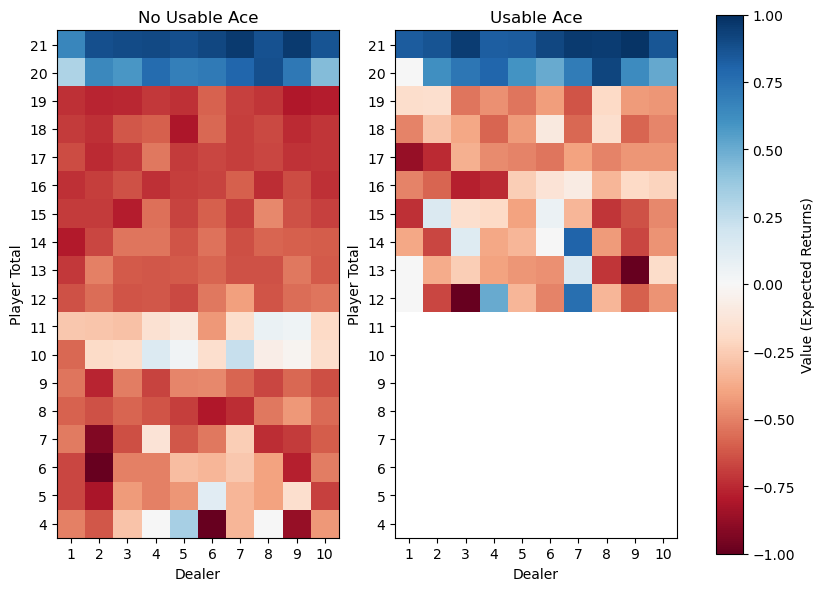

In [7]:
np.seterr(divide="ignore", invalid="ignore")
game_10k = policy_evaluation(10_000)
plot_value(game_10k[0])

>### 2. A  500.000 episodes

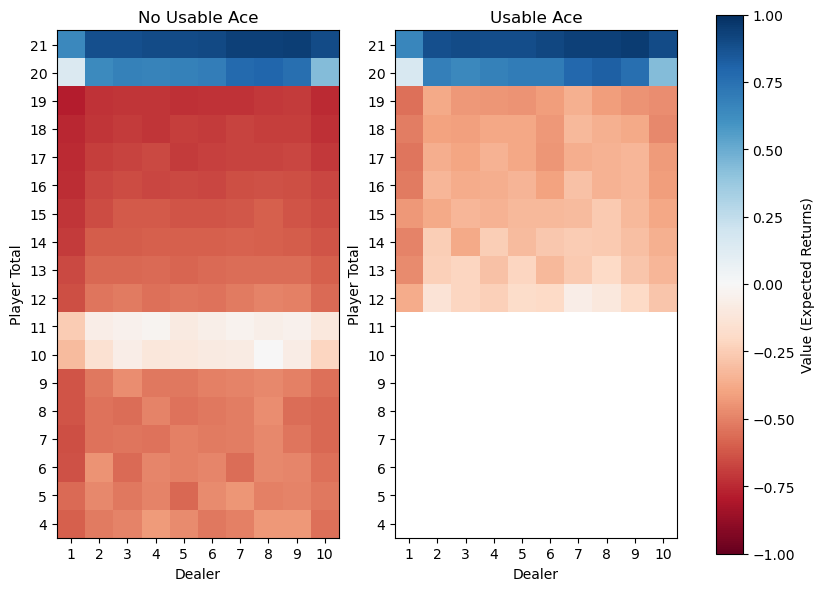

In [8]:
game_500k = policy_evaluation(500_000)
plot_value(game_500k[0])

>### 2. B  10.000 episodes

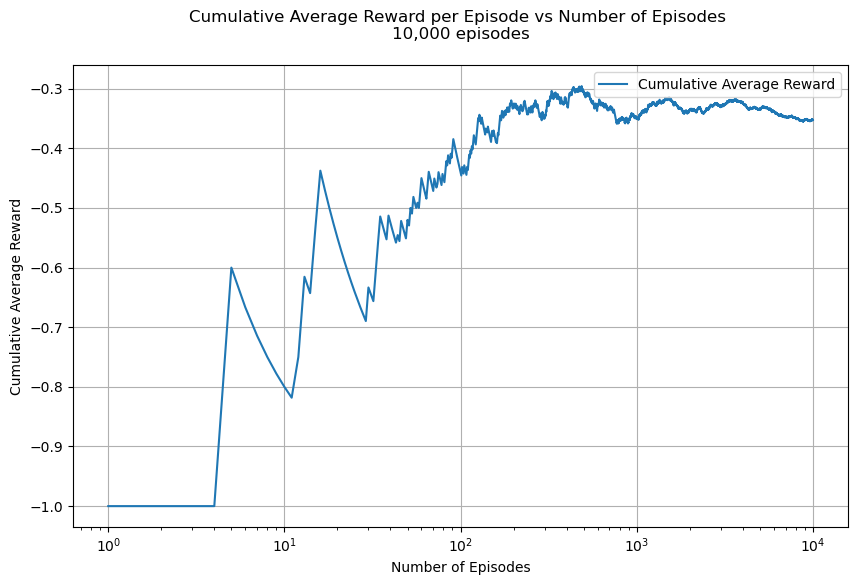

In [9]:
cumulative_average_reward_10k = game_10k[1]

episodes = range(1, len(cumulative_average_reward_10k) + 1)

plt.figure(figsize=(10, 6))
plt.plot(episodes, cumulative_average_reward_10k,
         label="Cumulative Average Reward")
plt.xscale("log")
plt.xlabel("Number of Episodes")
plt.ylabel("Cumulative Average Reward")
plt.title(
    "Cumulative Average Reward per Episode vs Number of Episodes \n10,000 episodes\n"
)
plt.legend()
plt.grid(True)
plt.show()

>### 2. B  500.000 episodes

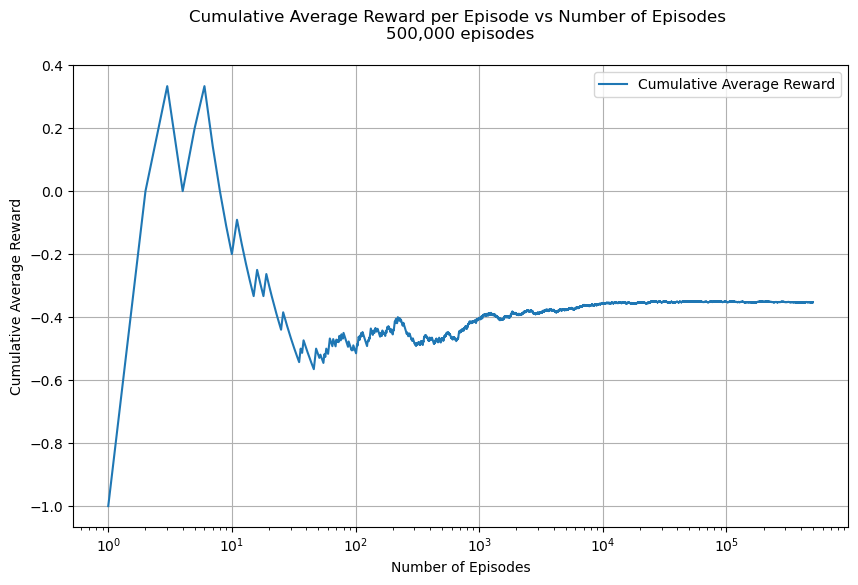

In [10]:
cumulative_average_reward_500k = game_500k[1]

episodes = range(1, len(cumulative_average_reward_500k) + 1)

plt.figure(figsize=(10, 6))
plt.plot(episodes, cumulative_average_reward_500k, label="Cumulative Average Reward")
plt.xscale("log")
plt.xlabel("Number of Episodes")
plt.ylabel("Cumulative Average Reward")
plt.title(
    "Cumulative Average Reward per Episode vs Number of Episodes \n500,000 episodes\n"
)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(
    f"The final cumulative average reward at 10,000 episodes is: {cumulative_average_reward_10k[-1]:.4f}"
)
print(
    f"The final cumulative average reward at 500,000 episodes is: {cumulative_average_reward_500k[-1]:.4f}"
)

The final cumulative average reward at 10,000 episodes is: -0.3528
The final cumulative average reward at 500,000 episodes is: -0.3529


## 3

### [40 points] Perform Monte Carlo Control

Now it's time to actually implement a reinforcement learning strategy that learns to play this version of Blackjack well, only through trial-and-error learning. Here, you will develop your Monte Carlo Control algorithm and evaluate its performance for our Blackjack-like game.

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the state value function and the action value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed. Varying $0 \leq N_0 < \inf$ will determine the amount of exploration the algorithm performs where the lower $N_0$ the less exploration and vice versa.

Show your results by plotting the optimal state value function: $v^*(s) = \max_a q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the 2018 edition (5.5 in the original edition) - sample code provided for the plots. Your results SHOULD be very similar to the plots in that text (although you will show your results with the player sum ranging from 2 to 21). For these plots include the following (note - code from the previous section of this assignment for state value function plotting and below for policy plotting are provided to help you to accomplish these):
1. When you have a useable ace, plot the value function with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the colormap and `imshow` to plot the value function that corresponds with those states. Plot the state value corresponding to each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the same states but without a usable ace.
3. Plot the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot can be an imshow plot with binary values - sample code provided).
4. Plot the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot can be an imshow plot with binary values - sample code provided).


**(b)** Plot the cumulative average return per episode vs the number of episodes (your x-axis should be log-scaled to clearly see the trend). What is the average return your control strategy was able to achieve? You'll know your method is working if you see a steady rise in your average returns over time.

*Note on convergence: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

*Note on sample code: the code provided for these questions is meant to be a helpful starting point - you are not required to fill it out exactly or use all components, but it is meant to help you as you begin thinking about this problem.*

**ANSWER**

In [12]:
def mc_control(episodes):
    N_player = 32
    N_dealer = 10
    N_ace = 2
    N_actions = 2

    avg_return = []
    N = 0
    N0 = 100  # Coefficient for controlling the level of exploration

    # Initialize the state value function, V, and the action value function, Q
    V = np.zeros((N_player, N_dealer, N_ace))
    q = np.zeros((N_player, N_dealer, N_ace, N_actions))

    # Initialize a variable counting the number of visits to each state
    # For the state value function
    nv_visits = np.zeros((N_player, N_dealer, N_ace))
    # For the action value function
    nq_visits = np.zeros((N_player, N_dealer, N_ace, N_actions))

    # Initialize a variable to add the total rewards to each state
    rewards = np.zeros((N_player, N_dealer, N_ace))

    # Initialize the policy to all always "stay" (all zeros)
    pi = np.zeros((N_player, N_dealer, N_ace))

    # Initialize the game
    B = Blackjack()

    # Convert the current state into a set of indices for the state value function
    def state_to_index_v(s):
        ace = 0
        if s[2]:
            ace = 1
        index = [s[0] - 1, s[1] - 1, ace]
        return index

    # Convert the current state into a set of indices for the action value function
    def state_to_index_av(s, a):
        ace = 0
        if s[2]:
            ace = 1
        index = [s[0] - 1, s[1] - 1, ace, int(a)]
        return index

    # Choose an action based on the policy, pi, and the current state, s, with
    # epsilon-greedy exploration
    def choose_action(pi, s):
        idxs = state_to_index_v(s)
        e = N0 / (N0 + np.sum(nq_visits[idxs[0], idxs[1], idxs[2], :]))
        if np.random.random() < e:
            return np.random.choice([0, 1])
        else:
            return np.argmax(q[idxs[0], idxs[1], idxs[2], :])

    # Run episodes of MC Control
    for episode in range(episodes):
        # Play a hand of blackjack
        s0 = B.deal()

        # Initialize a variable to hold the list of visited states and add the initial state
        index = state_to_index_v(s0)
        list_states = [index]
        state_action_pairs = []

        # Play through the hand following the policy
        s = B.step(choose_action(pi, s0))

        while True:
            if s[2]:
                # Episode is complete, update counts and rewards
                N += 1
                for state in list_states:
                    nv_visits[state[0], state[1], state[2]] += 1
                    rewards[state[0], state[1], state[2]] += s[1]

                # Collect state-action pairs and rewards for this episode
                state_action_pairs.append((s0, choose_action(pi, s0), s[1]))

                # Calculate episode reward
                episode_reward = s[1]

                # Update average return
                if N == 1:
                    avg_return.append(episode_reward)
                else:
                    avg_return.append(
                        (avg_return[-1] * len(avg_return) + episode_reward)
                        / (len(avg_return) + 1)
                    )

                break

            # Add current state to list of visited states
            index = state_to_index_v(s[0])
            list_states.append(index)

            # Take action based on policy
            s = B.step(choose_action(pi, s[0]))

        # Update q
        for state, action, reward in state_action_pairs:
            state_index = state_to_index_v(state)
            action_index = int(action)
            nq_visits[state_index[0], state_index[1], state_index[2], action_index] += 1
            n_visits_to_action_state = nq_visits[
                state_index[0], state_index[1], state_index[2], action_index
            ]
            q[state_index[0], state_index[1], state_index[2], action_index] += (
                reward - q[state_index[0], state_index[1], state_index[2], action_index]
            ) / n_visits_to_action_state

        # Update policy based on updated action-value function
        for state in list_states:
            state_index = state_to_index_v(state)
            pi[state_index[0], state_index[1], state_index[2]] = np.argmax(
                q[state_index[0], state_index[1], state_index[2]]
            )

    # Update the average returns
    V = rewards / nv_visits

    return (V, pi, avg_return)

In [13]:
# -------------------------------------------------
# Sample code for plotting your policy
# -------------------------------------------------
def plot_policy(pi):
    # Plot the policy
    drange = [1, 10]
    prange = [4, 21]
    plt.figure(figsize=(10, 7))
    axes = []
    axes.append(plt.subplot(1, 2, 1))
    plt.title("No Usable Ace")
    plt.imshow(
        pi[prange[0] - 1 : prange[1], :, 0],
        vmin=0,
        vmax=1,
        origin="lower",
        extent=(drange[0] - 0.5, drange[1] + 0.5, prange[0] - 0.5, prange[1] + 0.5),
        cmap="binary_r",
    )
    plt.xticks(np.arange(drange[0], drange[1] + 1, 1))
    plt.yticks(np.arange(prange[0], prange[1] + 1, 1))
    plt.ylabel("Player Total")
    plt.xlabel("Dealer")

    axes.append(plt.subplot(1, 2, 2))
    plt.title("Usable Ace")
    im = plt.imshow(
        pi[prange[0] - 1 : prange[1], :, 1],
        vmin=0,
        vmax=1,
        origin="lower",
        extent=(drange[0] - 0.5, drange[1] + 0.5, prange[0] - 0.5, prange[1] + 0.5),
        cmap="binary_r",
    )
    plt.xticks(np.arange(drange[0], drange[1] + 1, 1))
    plt.yticks(np.arange(prange[0], prange[1] + 1, 1))
    plt.ylabel("Player Total")
    plt.xlabel("Dealer")
    cbar = plt.colorbar(im, ax=axes)
    cbar.set_label("Action (Stay = 0, Hit = 1)")

>### 3. A  10.000 episodes

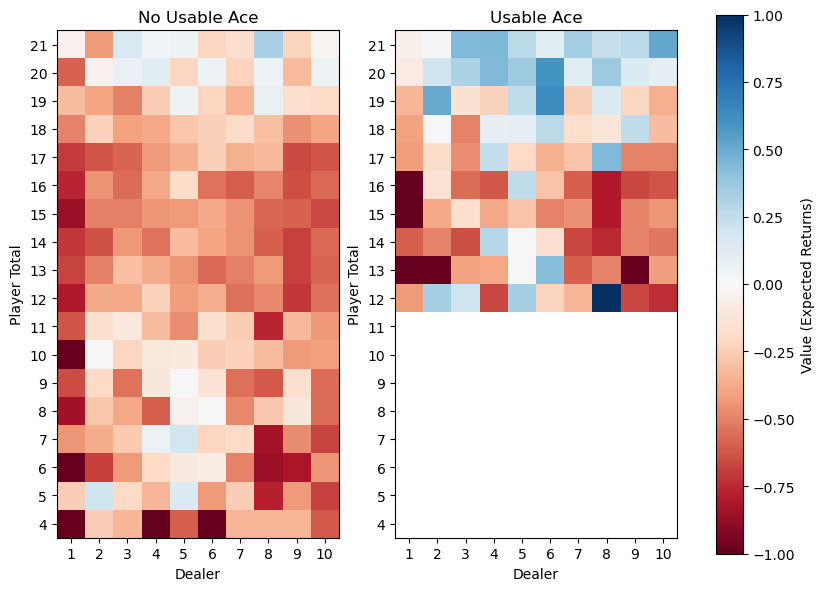

In [14]:
mc_control_1 = mc_control(10_000)
plot_value(mc_control_1[0])

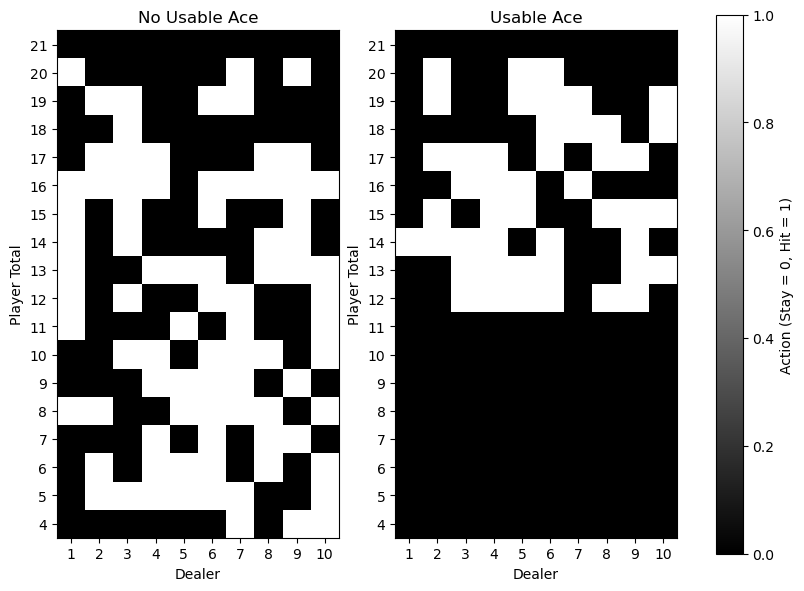

In [15]:
plot_policy(mc_control_1[1])

>### 3. A  50.000.000 episodes

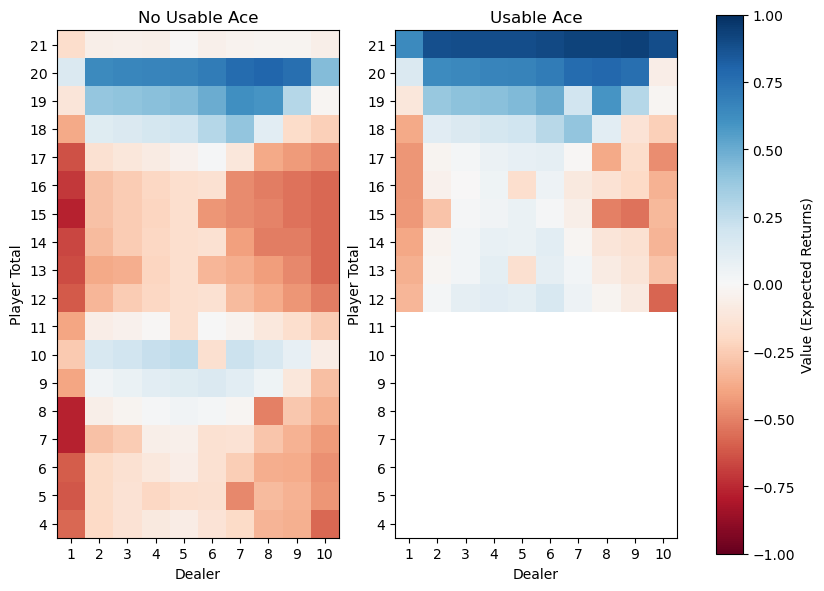

In [16]:
mc_control_2 = mc_control(50_000_000)
plot_value(mc_control_2[0])

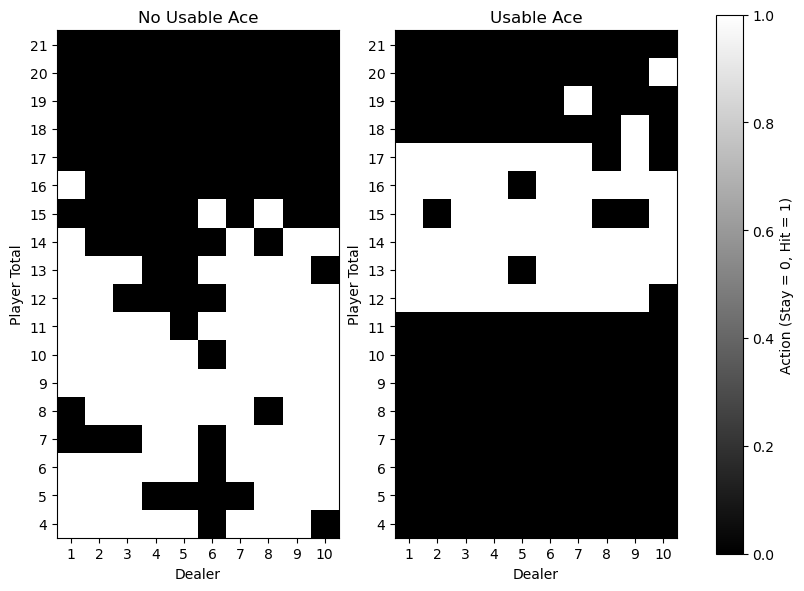

In [17]:
plot_policy(mc_control_2[1])

>### 3. B  10.000 episodes

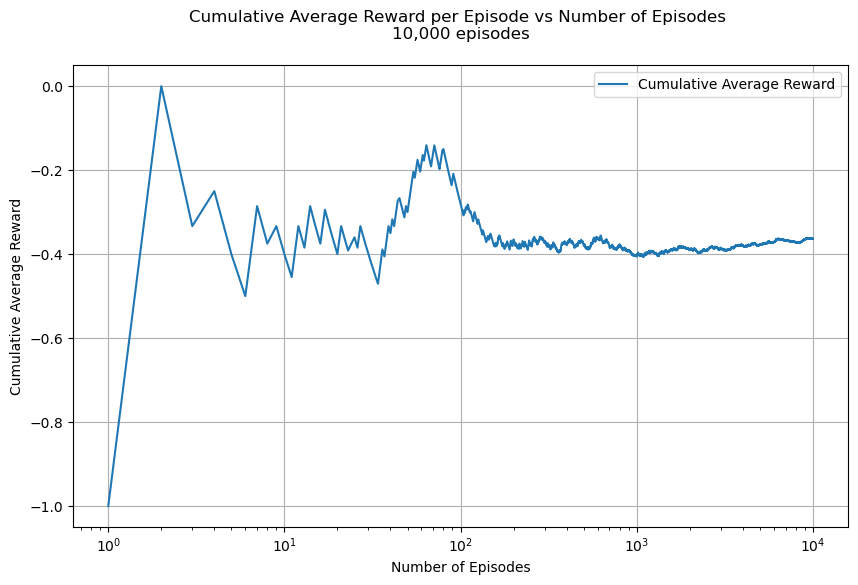

In [18]:
cumulative_average_reward_10k = mc_control_1[2]

episodes = range(1, len(cumulative_average_reward_10k) + 1)

plt.figure(figsize=(10, 6))
plt.plot(episodes, cumulative_average_reward_10k, label="Cumulative Average Reward")
plt.xscale("log")
plt.xlabel("Number of Episodes")
plt.ylabel("Cumulative Average Reward")
plt.title(
    "Cumulative Average Reward per Episode vs Number of Episodes \n10,000 episodes\n"
)
plt.legend()
plt.grid(True)
plt.show()

>### 3. B  50.000.000 episodes

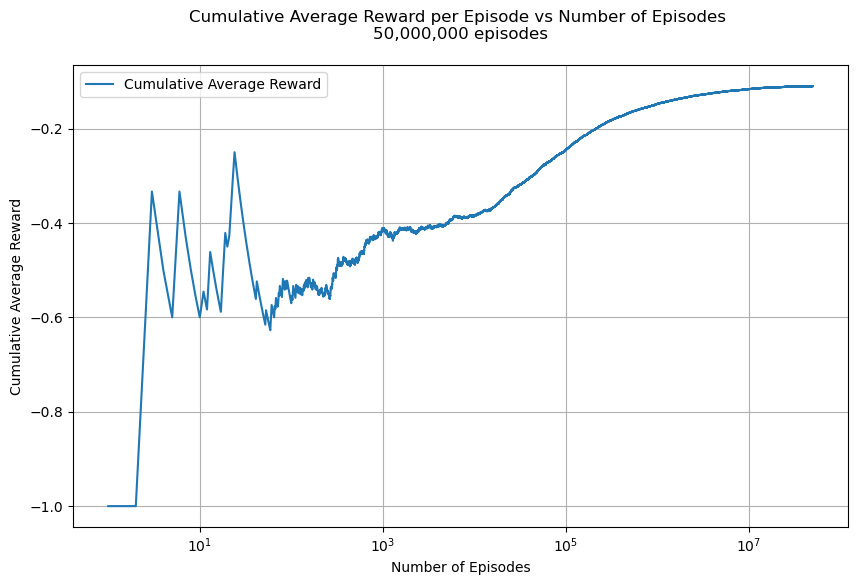

In [20]:
cumulative_average_reward_50M = mc_control_2[2]

episodes = range(1, len(cumulative_average_reward_50M) + 1)

plt.figure(figsize=(10, 6))
plt.plot(episodes, cumulative_average_reward_50M,
         label="Cumulative Average Reward")
plt.xscale("log")
plt.xlabel("Number of Episodes")
plt.ylabel("Cumulative Average Reward")
plt.title(
    "Cumulative Average Reward per Episode vs Number of Episodes \n50,000,000 episodes\n"
)
plt.legend()
plt.grid(True)
plt.show()

In [22]:
print(
    f"The final cumulative average reward at 10,000 episodes is: {cumulative_average_reward_10k[-1]:.4f}"
)
print(
    f"The final cumulative average reward at 50,000,000 episodes is: {cumulative_average_reward_50M[-1]:.4f}"
)

The final cumulative average reward at 10,000 episodes is: -0.3634
The final cumulative average reward at 50,000,000 episodes is: -0.1100


# 4

## [5 points] Discuss your findings

Compare the performance of your human control policy, in question 1, the naive policy from question 2, and the optimal control policy in question 3. 

**(a)** Which performs best? What was different about the policies developed for each and how may that have contributed to their comparative advantages?

**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not? *(assume the policy estimated from your MC control algorithm had **fully converged**)*

**ANSWER**

> ### 4. A 
>
> Regarding my human control approach, I opted for a simple strategy due to my preference for not spending much time thinking about the game and my lack of skill in card games. I decided to follow a basic rule: if I get an even number, I continue in the game; if I get an odd number, I decide to quit. Unfortunately, this strategy resulted in a mediocre performance.
>
>For the naive policy of hitting until reaching 20 or 21 and then standing. Although this strategy was more thoughtful than my human approach, it is still relatively simple and does not require prior training. However, this policy also has limitations and is not always effective in all game situations.
>
>As for Monte Carlo Control, this approach was more elaborate and effective in the long run. Using a trial-and-error learning algorithm, the agent learned to adjust its playing policy based on the rewards received during interaction with the environment. Although the process was computationally costly and slow, the final results showed a significant improvement in game performance. The resulting optimal policy maximized rewards over time and far exceeded human strategies and the naive policy.
>
>In summary, while human strategies and the naive policy are simple and easy to implement, their performance is limited compared to the more sophisticated approach of Monte Carlo Control. Although the latter requires more computational resources and execution time, it offers more promising results in terms of maximizing rewards in the game of blackjack.
>
> ### 4. B 
>
> Yes Knowing the full Markov Decision Process for this environment would likely enable us to create a better policy than what Monte Carlo Control can achieve alone, even when fully converged. With complete information about transition probabilities and rewards, we could employ more advanced algorithms like value iteration or policy iteration to directly compute the optimal policy. Additionally, having access to the full MDP would allow for a more nuanced consideration of complex game dynamics and interactions, potentially leading to a more refined and effective policy.
>
>However, even with a fully converged Monte Carlo Control algorithm, limitations remain. The convergence of Monte Carlo methods can be slow, and the resulting policy may not be globally optimal. 